In [ ]:
def mount_drive(dir):
  import os
  colab = 1
  if colab == 1:
    from google.colab import drive
    drive.mount('/content/drive', force_remount = True)
    current_folder = dir
    dest_folder = '/content/drive/My Drive/' + current_folder
    os.chdir(dest_folder)
    print('\n Current path: ' + os.getcwd())

mount_drive('')

Mounted at /content/drive

 Current path: /content/drive/My Drive


In [4]:
pip install rdkit selfies
pip install tensorflow

SyntaxError: invalid syntax (1631732962.py, line 1)

In [1]:
import numpy as np
import pandas as pd
from rdkit import Chem
import tensorflow as tf
from rdkit.Chem import AllChem
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
qm9 = pd.read_csv("qm9.csv")

In [ ]:
qm9 = qm9.drop(columns="mol_id")
qm9.head()

,smiles,A,B,C,mu,alpha,homo,lumo,gap,r2,...,u0,u298,h298,g298,cv,u0_atom,u298_atom,h298_atom,g298_atom,Morgan_fingerprint
0,C,157.71180,157.709970,157.706990,0.0000,13.21,-0.3877,0.1171,0.5048,35.3641,...,-40.478930,-40.476062,-40.475117,-40.498597,6.469,-395.999595,-398.643290,-401.014647,-372.471772,[0 0 0 ... 0 0 0]
1,N,293.60975,293.541110,191.393970,1.6256,9.46,-0.2570,0.0829,0.3399,26.1563,...,-56.525887,-56.523026,-56.522082,-56.544961,6.316,-276.861363,-278.620271,-280.399259,-259.338802,[0 0 0 ... 0 0 0]
2,O,799.58812,437.903860,282.945450,1.8511,6.31,-0.2928,0.0687,0.3615,19.0002,...,-76.404702,-76.401867,-76.400922,-76.422349,6.002,-213.087624,-213.974294,-215.159658,-201.407171,[0 0 0 ... 0 0 0]
3,C#C,0.00000,35.610036,35.610036,0.0000,16.28,-0.2845,0.0506,0.3351,59.5248,...,-77.308427,-77.305527,-77.304583,-77.327429,8.574,-385.501997,-387.237686,-389.016047,-365.800724,[0 0 0 ... 0 0 0]
4,C#N,0.00000,44.593883,44.593883,2.8937,12.99,-0.3604,0.0191,0.3796,48.7476,...,-93.411888,-93.409370,-93.408425,-93.431246,6.278,-301.820534,-302.906752,-304.091489,-288.720028,[0 0 0 ... 0 0 0]


In [ ]:
X_fingerprints = np.vstack(qm9["Morgan_fingerprint"].apply(lambda x: np.fromstring(x, sep=' ')).values)
X_properties = qm9.drop(columns=["smiles", "Morgan_fingerprint"]).values

X = np.hstack([X_fingerprints, X_properties])

<ipython-input-6-67d7935c0338>:1: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  X_fingerprints = np.vstack(qm9["Morgan_fingerprint"].apply(lambda x: np.fromstring(x, sep=' ')).values)


In [ ]:
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

In [ ]:
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (107108, 19) Test shape: (26777, 19)


In [ ]:
batch_s = 128

dat = tf.data.Dataset.from_tensor_slices(X_train)
dat = dat.shuffle(1000)
dat = dat.batch(batch_s, drop_remainder=True).prefetch(1)

In [ ]:
latent_dim = 100
input_dim = X_train.shape[1]

generator = models.Sequential([
    layers.Dense(128, activation="relu", input_shape =(latent_dim, )),
    layers.Dense(256, activation = "relu"),
    layers.Dense(input_dim, activation="tanh")
])

generator.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │          12,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 19)                  │           4,883 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,835 (198.57 KB)

 Trainable params: 50,835 (198.57 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
discrimanator = models.Sequential([
    layers.Dense(256, activation = "leaky_relu", input_shape=(input_dim,)),
    layers.Dense(128, activation = "leaky_relu"),
    layers.BatchNormalization(),
    layers.Dense(1, activation = "sigmoid")
])

discrimanator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 256)                 │           5,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,657 (151.00 KB)

 Trainable params: 38,401 (150.00 KB)

 Non-trainable params: 256 (1.00 KB)

In [ ]:
gan2 = keras.models.Sequential([generator, discrimanator])

In [ ]:
optimizer_d = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
optimizer_g = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

discrimanator.trainable = True

discrimanator.compile(loss='binary_crossentropy', optimizer=optimizer_d, metrics=['accuracy'])

gan2 = keras.models.Sequential([generator, discrimanator])
gan2.compile(loss="binary_crossentropy", optimizer=optimizer_g)

In [ ]:
gan2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 19)                  │          50,835 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 1)                   │          38,657 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 89,492 (349.58 KB)

 Trainable params: 89,236 (348.58 KB)

 Non-trainable params: 256 (1.00 KB)

In [ ]:
genarator, discrimanator = gan2.layers
epochs = 100

In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:
d_losses = []
g_losses = []

for epoch in range(epochs):
  idx = np.random.randint(0, X_train.shape[0], batch_s)
  real_samples = tf.gather(X_train, idx)

  z = tf.random.normal(shape =(batch_s, latent_dim))
  fake_samples = generator(z)

  real_labs = tf.ones((batch_s, 1))
  fake_labs = tf.zeros((batch_s, 1))

  d_loss_real = discrimanator.train_on_batch(real_samples, real_labs)
  d_loss_fake = discrimanator.train_on_batch(fake_samples, fake_labs)
  d_loss = 0.5 * (d_loss_real[0] + d_loss_fake[0])

  z = tf.random.normal(shape=(batch_s, latent_dim))
  g_loss = gan2.train_on_batch(z, real_labs)

  if epoch % 1 == 0:
    print(f"Epoch {epoch} | Loss D: {d_loss:.4f} | Loss G: {g_loss:.4f}")

  d_losses.append(d_loss)
  g_losses.append(g_loss)

Epoch 0 | Loss D: 0.8003 | Loss G: 0.8815
Epoch 1 | Loss D: 0.7873 | Loss G: 0.8323
Epoch 2 | Loss D: 0.7706 | Loss G: 0.8061
Epoch 3 | Loss D: 0.7582 | Loss G: 0.7870
Epoch 4 | Loss D: 0.7487 | Loss G: 0.7742
Epoch 5 | Loss D: 0.7419 | Loss G: 0.7638
Epoch 6 | Loss D: 0.7373 | Loss G: 0.7560
Epoch 7 | Loss D: 0.7339 | Loss G: 0.7493
Epoch 8 | Loss D: 0.7307 | Loss G: 0.7442
Epoch 9 | Loss D: 0.7280 | Loss G: 0.7401
Epoch 10 | Loss D: 0.7258 | Loss G: 0.7361
Epoch 11 | Loss D: 0.7240 | Loss G: 0.7334
Epoch 12 | Loss D: 0.7223 | Loss G: 0.7298
Epoch 13 | Loss D: 0.7208 | Loss G: 0.7267
Epoch 14 | Loss D: 0.7195 | Loss G: 0.7241
Epoch 15 | Loss D: 0.7183 | Loss G: 0.7216
Epoch 16 | Loss D: 0.7172 | Loss G: 0.7194
Epoch 17 | Loss D: 0.7162 | Loss G: 0.7171
Epoch 18 | Loss D: 0.7153 | Loss G: 0.7151
Epoch 19 | Loss D: 0.7145 | Loss G: 0.7131
Epoch 20 | Loss D: 0.7138 | Loss G: 0.7112
Epoch 21 | Loss D: 0.7132 | Loss G: 0.7095
Epoch 22 | Loss D: 0.7126 | Loss G: 0.7078
Epoch 23 | Loss D: 0.

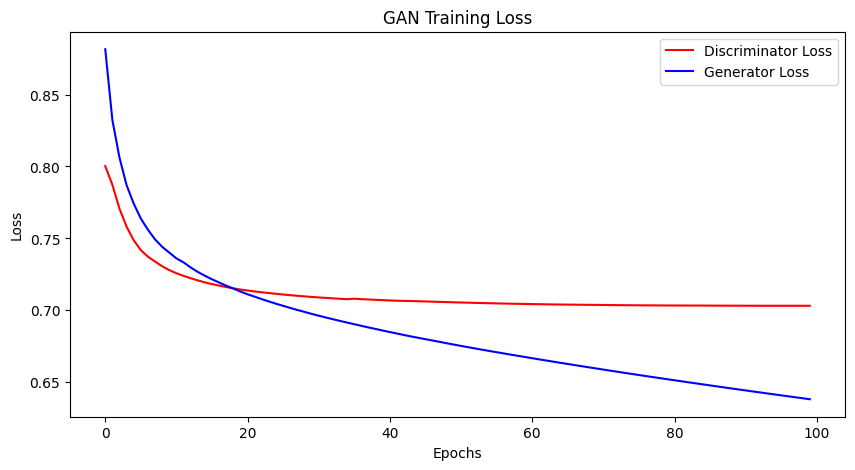

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(d_losses, label="Discriminator Loss", color='red')
plt.plot(g_losses, label="Generator Loss", color='blue')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("GAN Training Loss")
plt.legend()
plt.show()